## Let us perform Web Scraping using BeautifulSoup 

Importing the required libraries and extracting the Movie reviews and their ratings

In [86]:
from bs4 import BeautifulSoup

In [87]:
soup = BeautifulSoup(open("1.html",encoding="utf8"), "html.parser")

Let us take a look at the html structure 

In [88]:
movie_containers = soup.find_all('div' , class_ = 'review-container')
print(type(movie_containers))
print(len(movie_containers))

<class 'bs4.element.ResultSet'>
1124


We can see there are 1124 containers consisting of the reviews and the ratings

Let us try to extract the reviews

In [89]:
first_movie = movie_containers[0]
first_movie.a.text

" Finally, a Show that stays true to it's written roots\n"

Let us try to find the ratings of the reviews

In [90]:
temp = first_movie.span.text

In [91]:
temp

'\n\n\n\n\n\n9/10\n'

We can see that the reviews and ratings require cleaning which we will deal with it later

Let us try to extract all the reviews and the ratings

In [92]:
# Lists to store the scraped data in
reviews = []
ratings = []

# Extract data from individual movie container
for container in movie_containers:
    
    #review
    review = container.a.text
    reviews.append(review)
    
    #rating
    rating = container.span.text
    ratings.append(rating)
   

Let us try to put all the ratings into a dataframe

In [93]:
import pandas as pd
import numpy as np

test_df = pd.DataFrame({'Review': reviews,'Rating': ratings})
print(test_df.info())
test_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1124 entries, 0 to 1123
Data columns (total 2 columns):
Review    1124 non-null object
Rating    1124 non-null object
dtypes: object(2)
memory usage: 17.6+ KB
None


,Review,Rating
0,"Finally, a Show that stays true to it's writt...",\n\n\n\n\n\n9/10\n
1,Excellent adaptation.\n,\n\n\n\n\n\n10/10\n
2,One of the most stunning shows on television\n,\n\n\n\n\n\n10/10\n
3,Lord of the Rings - I think not!\n,\n\n\n\n\n\n10/10\n
4,Fantasy has never seemed so real\n,\n\n\n\n\n\n10/10\n


And woah we have scrapped all the reviews and the ratings 
Pandas do actualy make our work easier!

Let us perform cleaning on the reviews and the ratings

In [94]:
test_df.loc[:, 'Rating'] = test_df['Rating'].str[6:8]

In [95]:
test_df.loc[:, 'Rating'] = test_df['Rating'].str.replace('/', '')
test_df.loc[:, 'Review'] = test_df['Review'].str.replace('\n', '')
test_df.loc[:, 'Rating'] = test_df['Rating'].str.replace('-', '')

In [96]:
import re
def split_it(rating):
    return re.sub('[a-zA-Z]+','NaN', rating)

In [97]:
test_df['Rating'] = test_df['Rating'].apply(split_it)

In [98]:
test_df = test_df[test_df.Rating.str.contains("NaN") == False]

In [99]:
test_df['Rating'] = test_df['Rating'].apply(pd.to_numeric)

In [100]:
test_df.head()

,Review,Rating
0,"Finally, a Show that stays true to it's writt...",9.0
1,Excellent adaptation.,10.0
2,One of the most stunning shows on television,10.0
3,Lord of the Rings - I think not!,10.0
4,Fantasy has never seemed so real,10.0


We can see that we have cleaned the Ratings and the Reviews
There might be some redundency in the cleaning which I will update later

In [101]:
import seaborn as sns

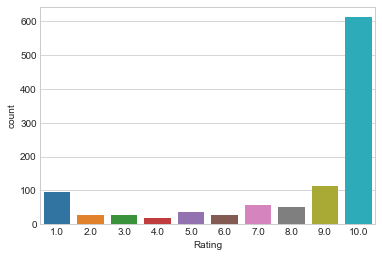

In [157]:
sns.countplot(test_df['Rating'])

We can see that there are some Ratings above 10 that we need to get rid of.

In [105]:
test_df = test_df[test_df.Rating <= 10]

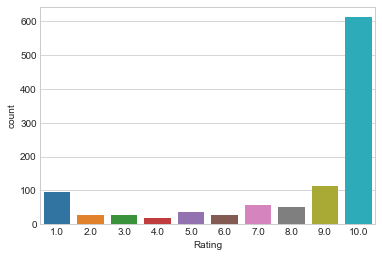

In [159]:
sns.countplot(test_df['Rating'])

Let us look at the descriptions

In [160]:
test_df.describe()

,Rating,Review Length
count,1065.000000,1065.000000
mean,8.071362,32.492958
std,3.015090,20.416624
min,1.000000,4.000000
25%,7.000000,18.000000
50%,10.000000,28.000000
75%,10.000000,42.000000
max,10.000000,166.000000


Let us look if there is a relation between a review length and a Rating

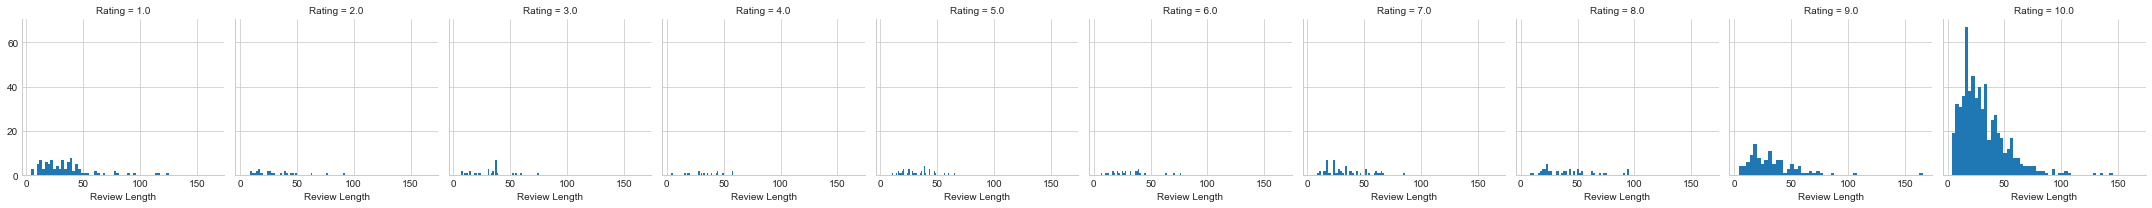

In [108]:
test_df['Review']=test_df['Review'].astype(str)
test_df['Review Length']=test_df['Review'].apply(len)

g = sns.FacetGrid(data=test_df, col='Rating')
g.map(plt.hist, 'Review Length', bins=50)

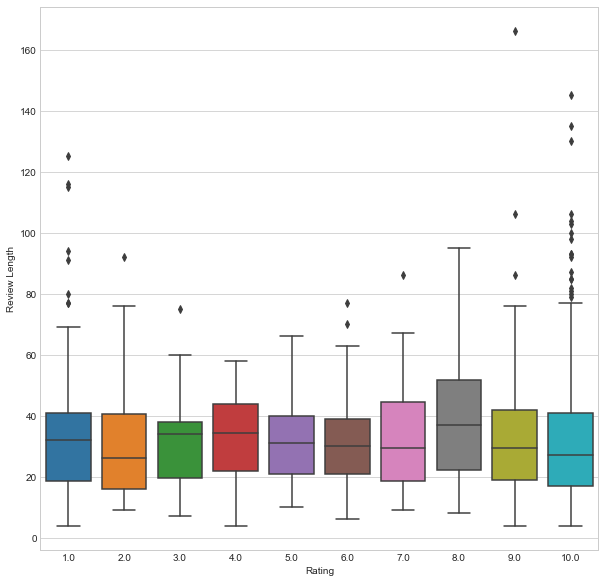

In [161]:
plt.figure(figsize=(10,10))
sns.boxplot(x='Rating', y='Review Length', data=test_df)

We can see that Reviews with ratings 1 and and 8 are the longest

Let us try to use machine learning and use NLP analytics

In [111]:
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize

In [164]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Akshay\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Let us try to extract all the words and try to perform analysis on it

In [113]:
a = test_df['Review'].str.lower().str.cat(sep=' ')

In [114]:
# removes punctuation,numbers and returns list of words
b = re.sub('[^A-Za-z]+', ' ', a)

In [115]:
#remove all the stopwords from the text
stop_words = list(get_stop_words('en'))         
nltk_words = list(stopwords.words('english'))   
stop_words.extend(nltk_words)

newStopWords = ['game','thrones', 'bran', 'stark', 'dragons']
stop_words.extend(newStopWords)

In [168]:
word_tokens = word_tokenize(b)

We have extracted all the words in the reviews. Let us find the total length

In [169]:
len(word_tokens)

6030

We will now remove the stop words from the reviews

In [118]:
filtered_sentence = []
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)

In [170]:
len(filtered_sentence)

3599

We have removed all the stop words and reduced the size by half.

In [171]:
# Remove characters which have length less than 2  
without_single_chr = [word for word in filtered_sentence if len(word) > 2]

# Remove numbers
cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()]   

Let us look at the top 10 most used words in a review.

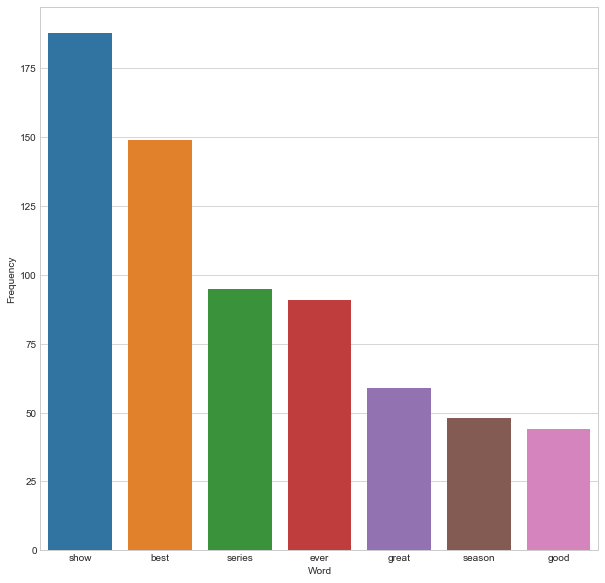

In [172]:
top_N = 100
word_dist = nltk.FreqDist(cleaned_data_title)
rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])

plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(7))

We can see that the most common words are positive indicating how great Game of thrones is!

In [122]:
from wordcloud import WordCloud, STOPWORDS

In [173]:
def wc(data,bgcolor,title):
    plt.figure(figsize = (100,100))
    wc = WordCloud(background_color = bgcolor, max_words = 1000,  max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

Let us visualise the most common words

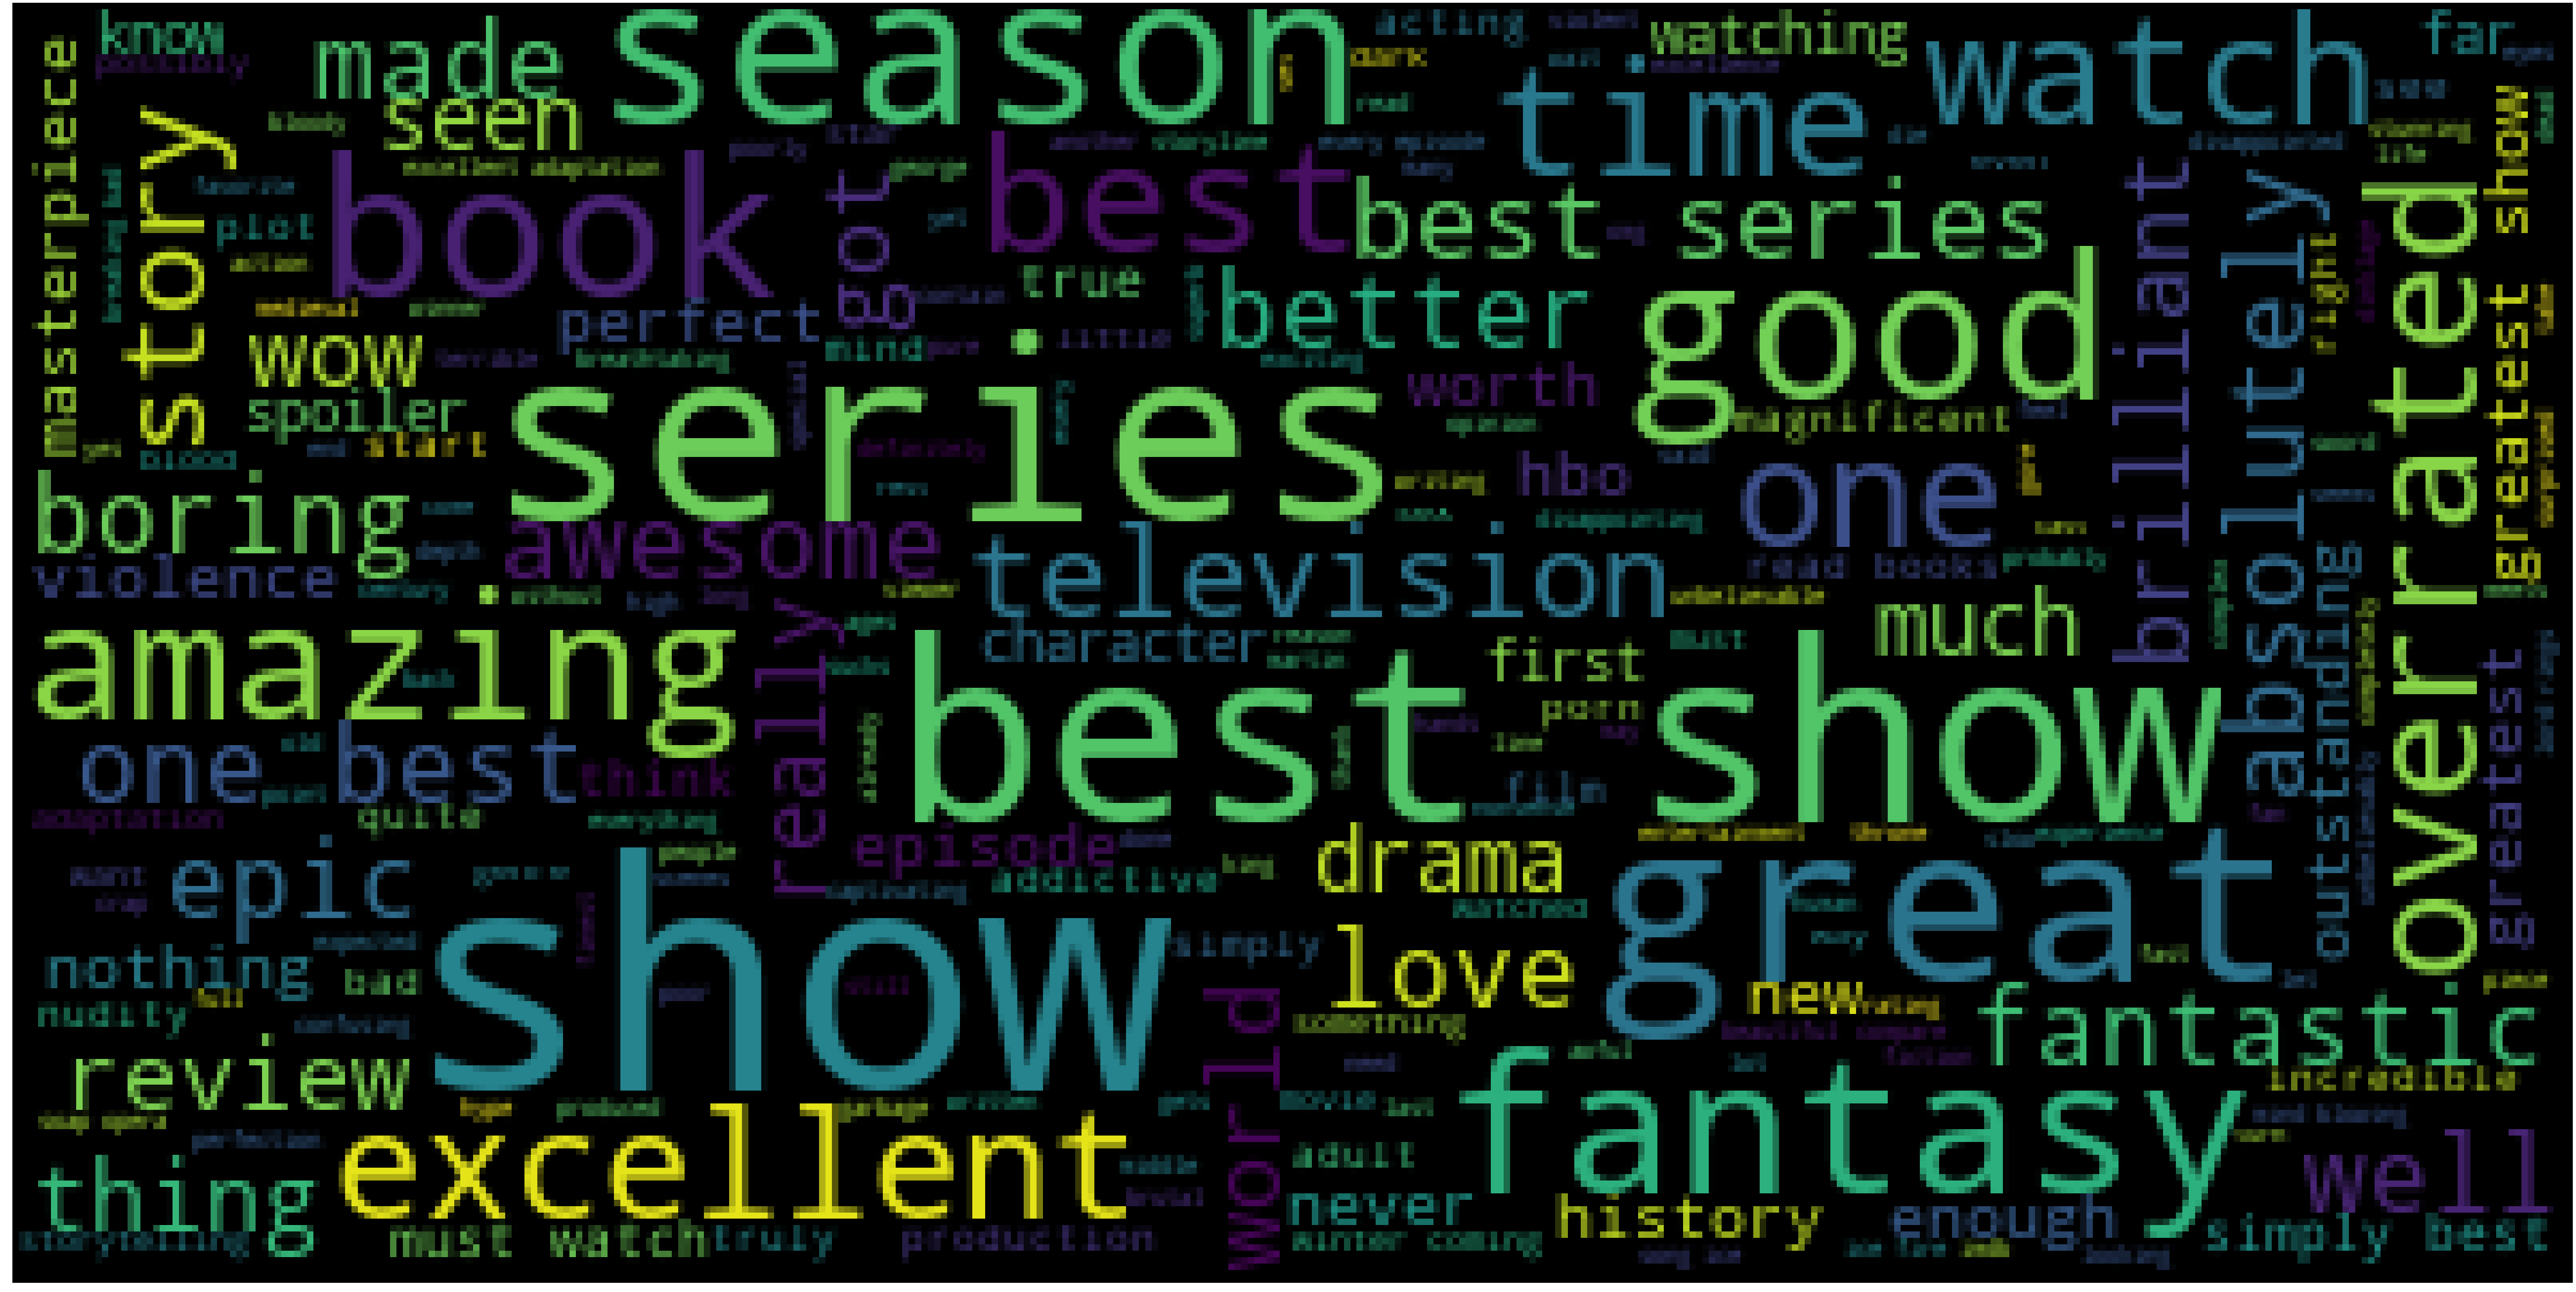

In [175]:
wc(cleaned_data_title,'black','Most Used Words')

Let us try to perform analysis on the entire review rather than all the words.
For this we make use of the TextBlob

In [125]:
from textblob import TextBlob

bloblist_desc = list()

df_review_str=test_df['Review'].astype(str)

In [176]:
for row in df_review_str:
    blob = TextBlob(row)
    bloblist_desc.append((row,blob.sentiment.polarity, blob.sentiment.subjectivity))
    df_polarity_desc = pd.DataFrame(bloblist_desc, columns = ['Review','sentiment','polarity'])

We will try to perform sentimental analysis and try to classify whether a review is a positive or negative

In [127]:
df_polarity_desc.head()

,Review,sentiment,polarity
0,"Finally, a Show that stays true to it's writt...",0.175,0.825
1,Excellent adaptation.,1.000,1.000
2,One of the most stunning shows on television,0.500,0.750
3,Lord of the Rings - I think not!,0.000,0.000
4,Fantasy has never seemed so real,0.200,0.300


In [178]:
def f(df_polarity_desc):
    if df_polarity_desc['sentiment'] >= 0:
        val = "Positive Review"
    elif df_polarity_desc['sentiment'] >= -0.09:
        val = "Neutral Review"
    else:
        val = "Negative Review"
    return val

After looking at the sentiments I have used the above values. This is a personal perference which you can change according to your choice.

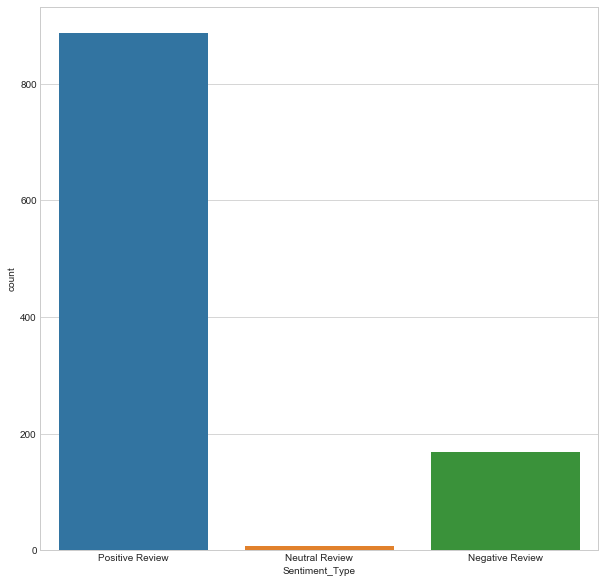

In [129]:
df_polarity_desc['Sentiment_Type'] = df_polarity_desc.apply(f, axis=1)

plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.countplot(x="Sentiment_Type", data=df_polarity_desc)

In [130]:
positive_reviews=df_polarity_desc[df_polarity_desc['Sentiment_Type']=='Positive Review']
negative_reviews=df_polarity_desc[df_polarity_desc['Sentiment_Type']=='Negative Review']

In [179]:
negative_reviews.head()

,Review,sentiment,polarity,Sentiment_Type
15,Heads up for GAME OF THRONES,-0.400000,0.400000,Negative Review
22,"As expected, some will love it, some will hat...",-0.133333,0.633333,Negative Review
36,Possibly the worst storyline I will ever enco...,-0.500000,1.000000,Negative Review
42,On finding Game of Thrones on VHS,-0.400000,0.400000,Negative Review
43,Unbelievably awful,-1.000000,1.000000,Negative Review


Let us look at the most used words in all the positive reviews

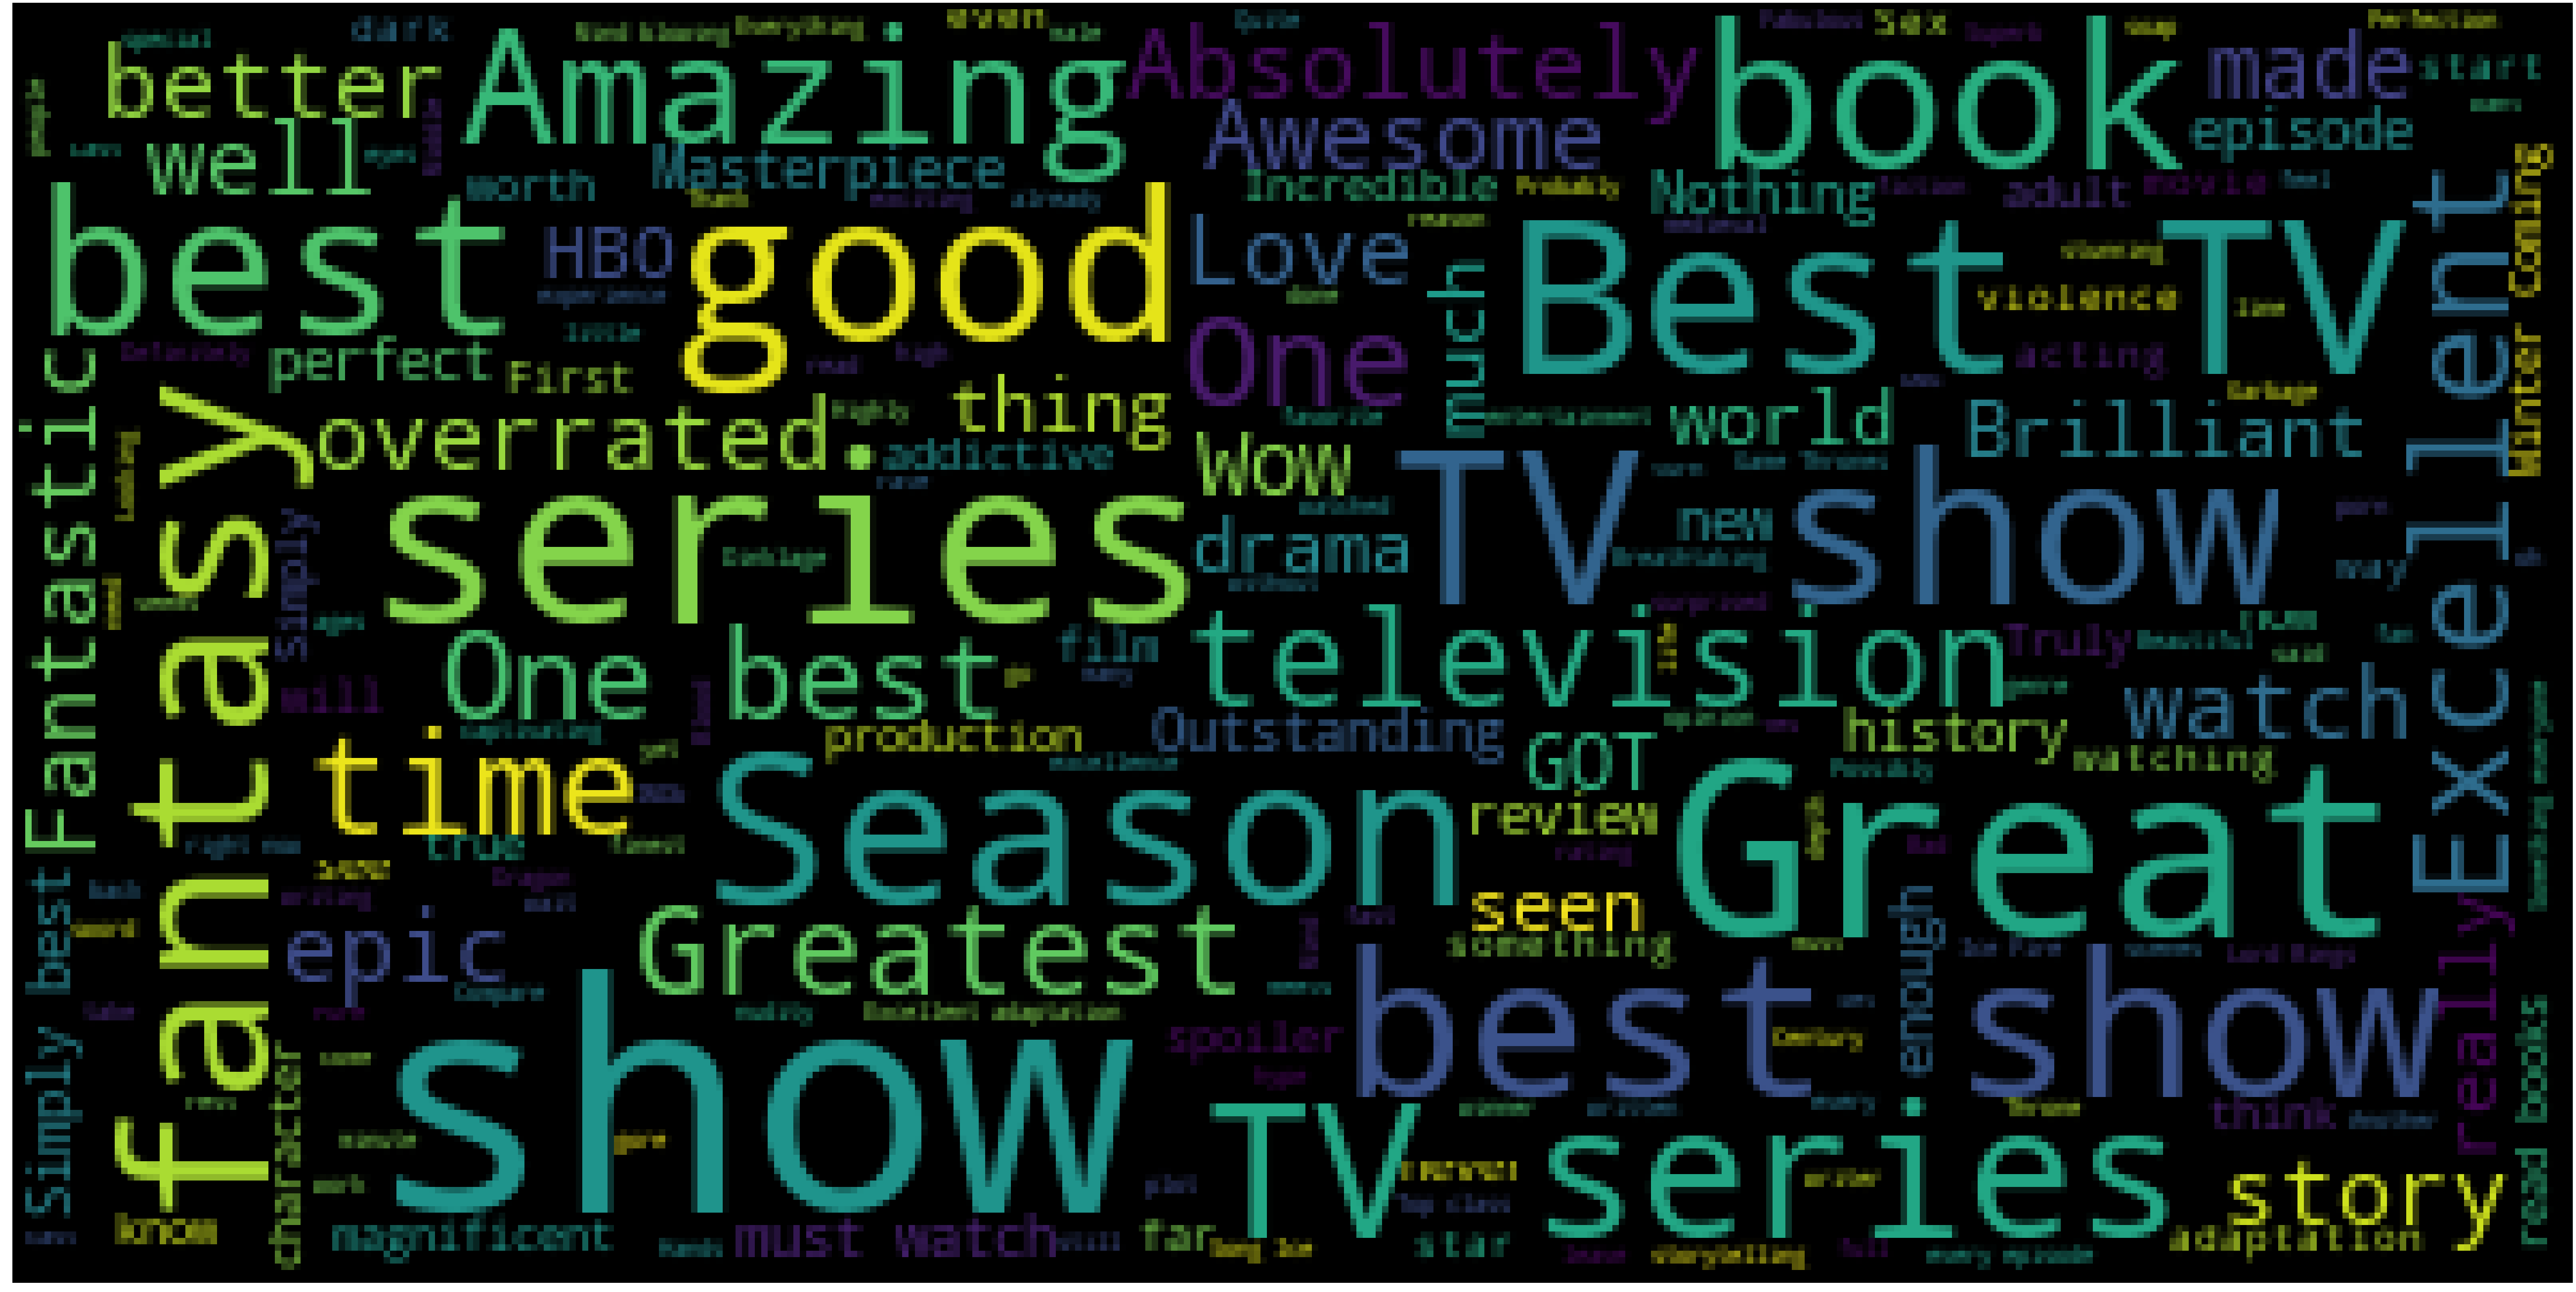

In [180]:
wc(positive_reviews['Review'],'black','Most Used Words')

Let us look at the most used words in all the negative reviews

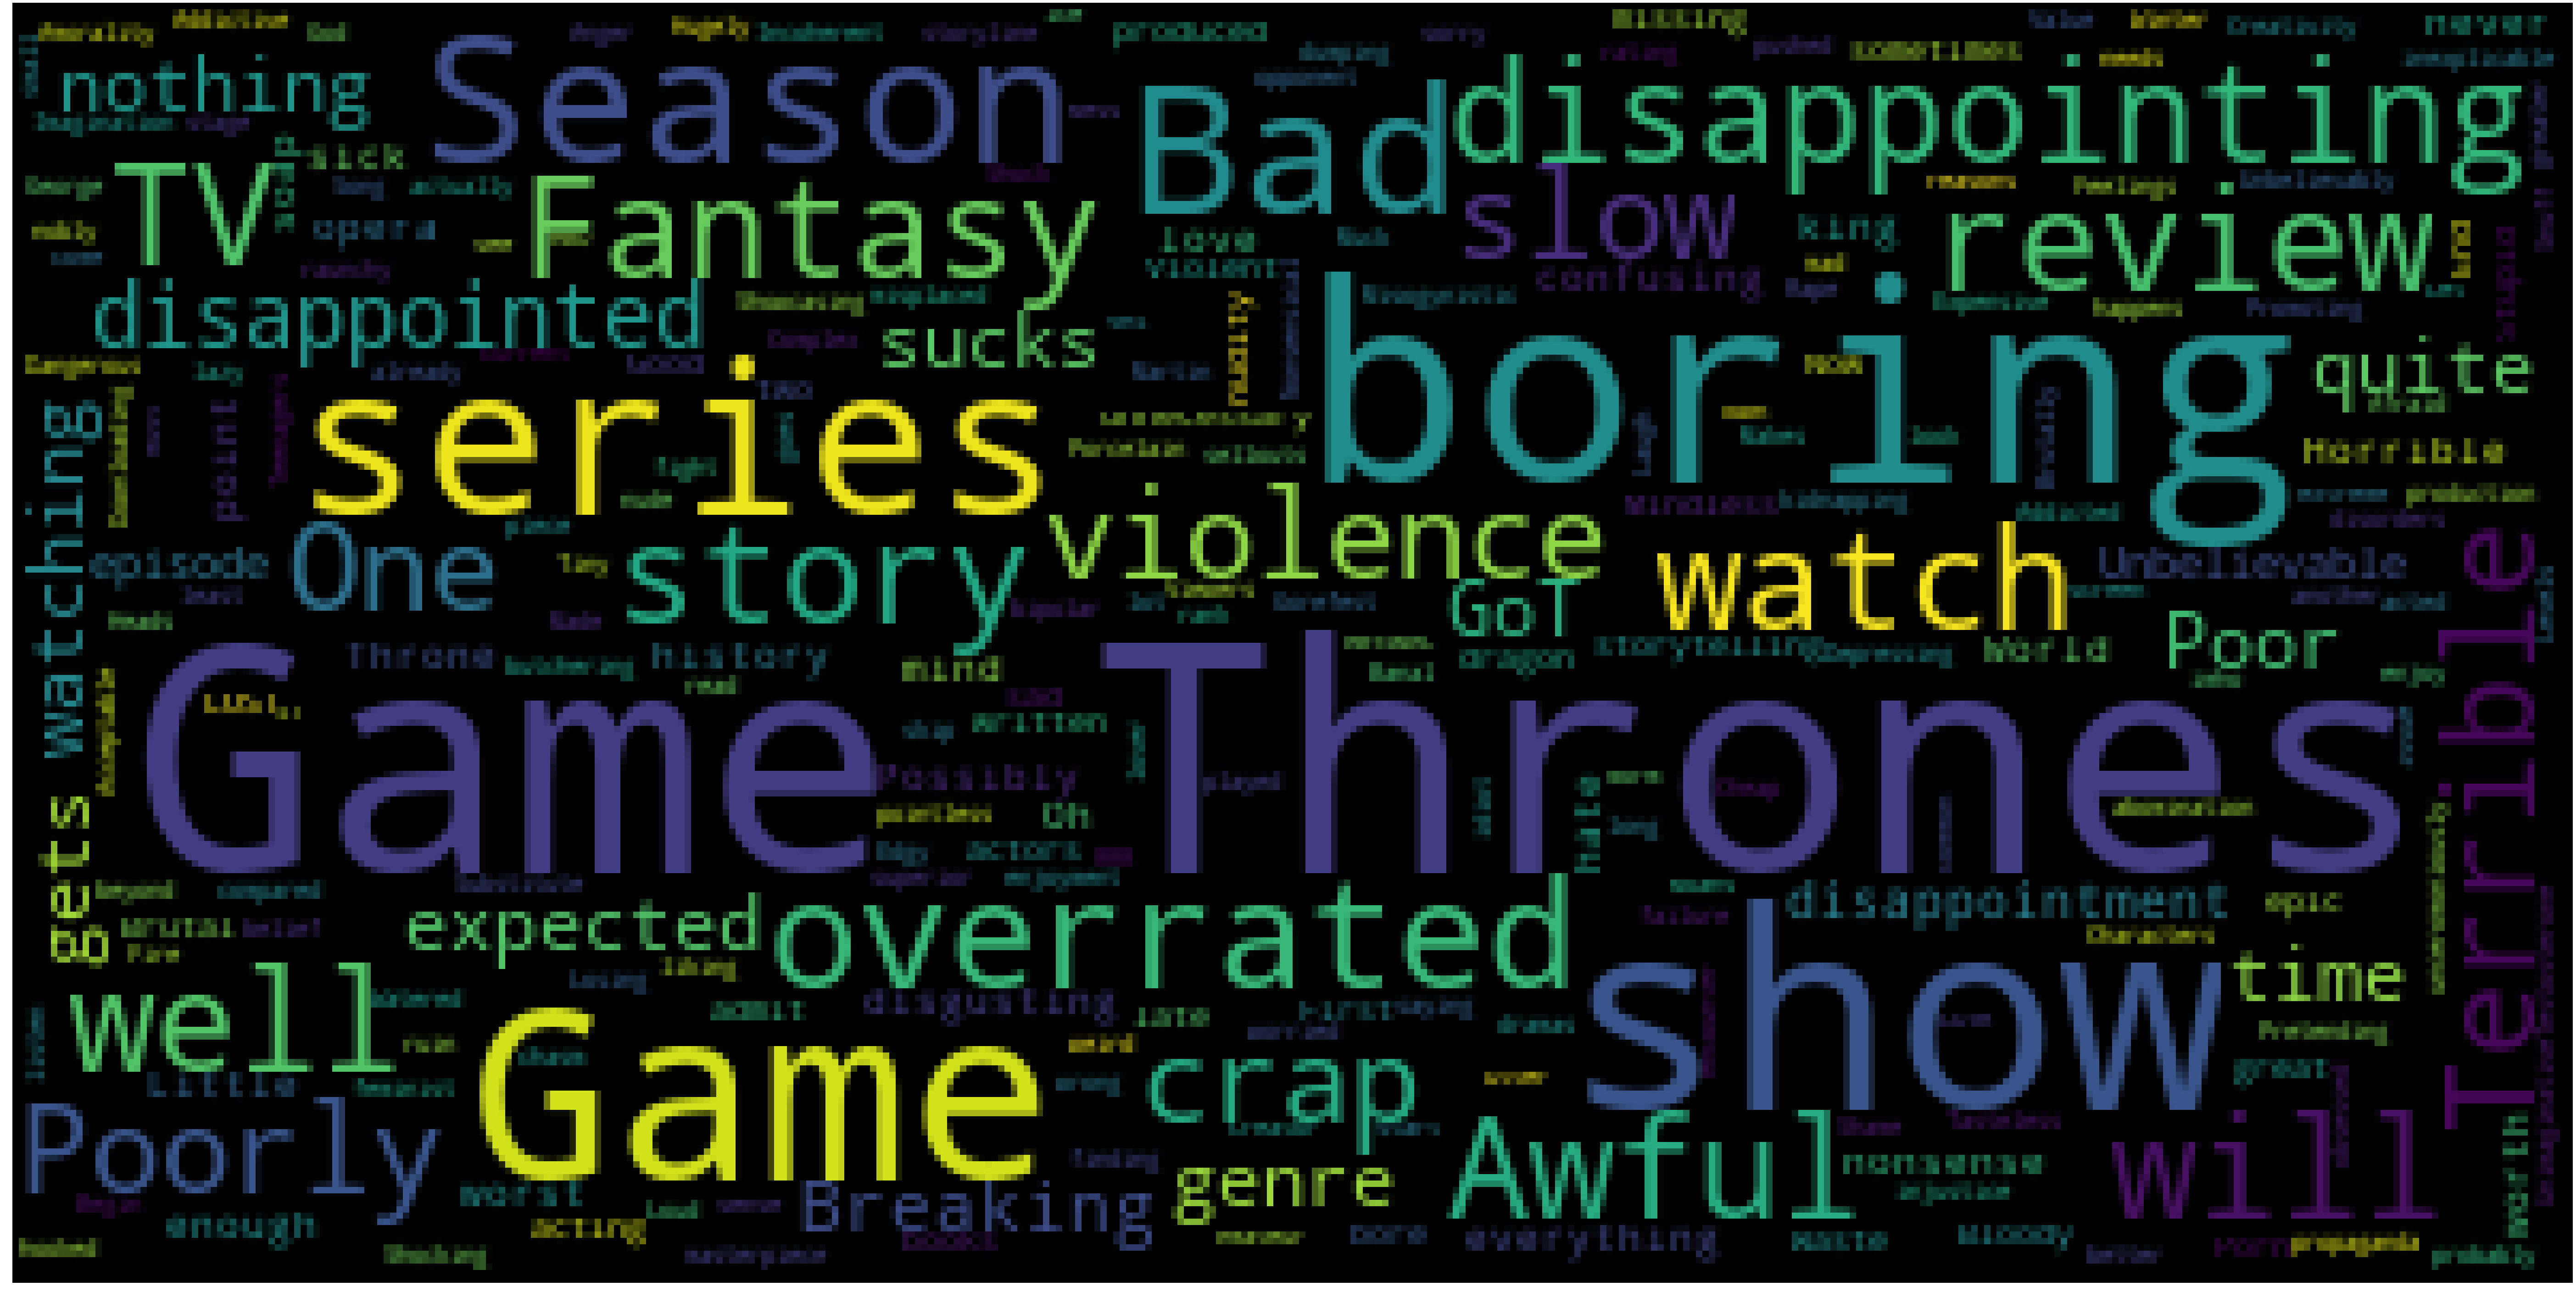

In [133]:
wc(negative_reviews['Review'],'black','Most Used Words')

In [182]:
import string
def text_process(review):
    nopunc=[word for word in review if word not in string.punctuation]
    nopunc=''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

Let us now train a model 
We are taking only review with ratings 1 and 10 to perform the analysis to make the analysis more simple.

In [135]:
test_df=test_df.dropna(axis=0,how='any')
rating_class = test_df[(test_df['Rating'] == 1) | (test_df['Rating'] == 10)]
X_review=rating_class['Review']
y=rating_class['Rating']

In [136]:
from sklearn.feature_extraction.text import CountVectorizer
bow_transformer=CountVectorizer(analyzer=text_process).fit(X_review)

In [137]:
X_review = bow_transformer.transform(X_review)

In [183]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_review, y, test_size=0.3, random_state=101)

Let us train a model using Multinomial Naive Bayes as it works great on text.

In [139]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train)
predict=nb.predict(X_test)

Let us find the accuracy, precision and recall

In [184]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(confusion_matrix(y_test, predict))
print('\n Accuracy:')
print(accuracy_score(y_test, predict))
print(classification_report(y_test, predict))

[[ 14  26]
 [ 14 159]]

 Accuracy:
0.812206572769953
             precision    recall  f1-score   support

        1.0       0.50      0.35      0.41        40
       10.0       0.86      0.92      0.89       173

avg / total       0.79      0.81      0.80       213



We have a 81 percent accuracy but a very recall score indicating that movies with ratings 1's
are not classified properly this maybe due to a large ratio of positive review. 
Hence it has a bad recall.


Let us test our model

In [141]:
rating_positive=test_df['Review'][6]
rating_positive

' This TV series is magnificent!'

In [142]:
rating_postive_transformed = bow_transformer.transform([rating_positive])
nb.predict(rating_postive_transformed)[0]

10.0

In [143]:
rating_negative=test_df['Review'][54]
rating_negative

' disgusting, overrated, pointless'

In [144]:
rating_negative_transformed = bow_transformer.transform([rating_negative])
nb.predict(rating_negative_transformed)[0]

1.0

As we can see that we have a skewed data set and let us try to improve recall by performing undersampling

In [145]:
ratings_1 = (rating_class['Rating']==1).sum()
ratings_1_indices = np.array(rating_class[rating_class.Rating == 1].index)


In [146]:
ratings_10_indices = rating_class[rating_class.Rating == 10].index


random_normal_indices = np.random.choice(ratings_10_indices, ratings_1, replace = False)
random_normal_indices = np.array(random_normal_indices)

under_sample_indices = np.concatenate([ratings_1_indices,random_normal_indices])





In [147]:
undersample = rating_class.ix[under_sample_indices]

X_undersample = undersample.ix[:, undersample.columns != 'Rating']
y_undersample = undersample.ix[:, undersample.columns == 'Rating']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-

In [148]:
print("Percentage of 10 ratings: ", len(undersample[undersample.Rating == 10])/len(undersample))
print("Percentage of 1 ratings: ", len(undersample[undersample.Rating == 1])/len(undersample))
print("Total number of examples in resampled data: ", len(undersample))

Percentage of 10 ratings:  0.5
Percentage of 1 ratings:  0.5
Total number of examples in resampled data:  190


In [149]:
X_review_us = X_undersample['Review']

In [150]:
X_review_us = bow_transformer.transform(X_review_us)

In [151]:
X_train_us, X_test_us, y_train_us, y_test_us = train_test_split(X_review_us, y_undersample, test_size=0.3, random_state=101)

In [152]:
nb.fit(X_train_us, y_train_us)
predict_us=nb.predict(X_test_us)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [187]:
print(confusion_matrix(y_test_us, predict_us))
print('\n Accuracy:')
print(accuracy_score(y_test_us, predict_us))
print(classification_report(y_test_us, predict_us))

[[16 10]
 [17 14]]

 Accuracy:
0.5263157894736842
             precision    recall  f1-score   support

        1.0       0.48      0.62      0.54        26
       10.0       0.58      0.45      0.51        31

avg / total       0.54      0.53      0.52        57



We can see a reduced accuracy but we have increased the recall now let us try to use this model on the entire data

In [154]:
nb.fit(X_train_us, y_train_us)
predict_entire=nb.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [188]:
print(confusion_matrix(y_test, predict_entire))
print('\n Accuracy:')
print(accuracy_score(y_test, predict_entire))
print(classification_report(y_test, predict_entire))

[[ 36   4]
 [ 54 119]]

 Accuracy:
0.7276995305164319
             precision    recall  f1-score   support

        1.0       0.40      0.90      0.55        40
       10.0       0.97      0.69      0.80       173

avg / total       0.86      0.73      0.76       213



Although, our overall accuracy has decreased. We have increased the recall to 90 percent.
Hence our model can classify review with 1 rating better. <br>
Comparing with the original model without undersampling

In [156]:
print(confusion_matrix(y_test, predict))
print('\n Accuracy:')
print(accuracy_score(y_test, predict))
print(classification_report(y_test, predict))

[[ 14  26]
 [ 14 159]]

 Accuracy:
0.812206572769953
             precision    recall  f1-score   support

        1.0       0.50      0.35      0.41        40
       10.0       0.86      0.92      0.89       173

avg / total       0.79      0.81      0.80       213

